<a href="https://colab.research.google.com/github/porcupinetreeforlife/Neural-Networks-and-Deep-Learning-Week-2-Assignment/blob/main/logistic_regression_cat_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Logistic Regression Classifier

Objective: Build a logistic regression classifier to identify images of cats.

## 1 - Import necessary libraries and load the dataset

In [55]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import scipy
from PIL import Image
from scipy import ndimage
from google.colab import drive

%matplotlib inline

In [56]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [57]:
!pwd

/content


In [58]:
def load_dataset ():
  train_dataset = h5py.File('/content/drive/MyDrive/Datasets/train_catvnoncat.h5', "r")
  train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # your train set features
  train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # your train set labels

  test_dataset = h5py.File('/content/drive/MyDrive/Datasets/test_catvnoncat.h5', "r")
  test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # your test set features
  test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # your test set labels

  classes = np.array(test_dataset["list_classes"][:]) # the list of classes

  train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
  test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))

  return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

In [59]:
# Load the dataset from Google Drive

train_set_x_orig, train_set_y, test_set_x_orig, test_set_y, classes = load_dataset()

## 2 - Understand the dataset and perform any necessary transformations

y = 0, it's a 'non-cat' picture.


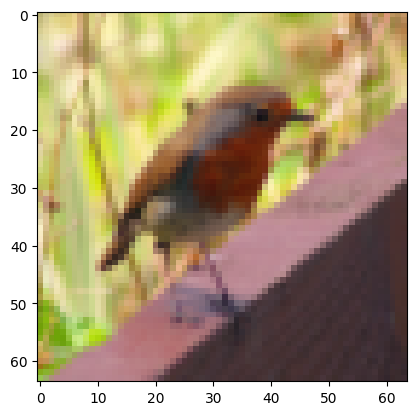

In [60]:
# Show any sample image from the dataset

index = 10
plt.imshow(train_set_x_orig[index])
print("y = " + str(train_set_y[0, index]) +
      ", it's a '" + classes[np.squeeze(train_set_y[:, index])].decode("utf-8") +
      "' picture.")

y = 1, it's a 'cat' picture.


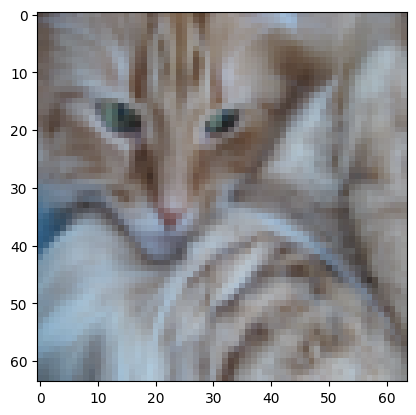

In [61]:
# Find the index of the first image of a cat and load the image

# Define the condition
condition = train_set_y[0, :] == 1

# Find all the indices that satisfy the given condition
indices = np.where(condition)

# Find the first element that satisfies the condition, provided it exists, and print the image
if len(indices[0]) > 0:
  first_index = indices[0][0]

  plt.imshow(train_set_x_orig[first_index])
  print("y = " + str(train_set_y[0, first_index]) +
        ", it's a '" + classes[np.squeeze(train_set_y[:, first_index])].decode("utf-8") +
        "' picture.")

In [62]:
# Find number of training examples, number of test examples and size of each image

m_train = train_set_x_orig.shape[0]
m_test = test_set_x_orig.shape[0]
num_px = train_set_x_orig.shape[1]

print("Number of training examples = " + str(m_train))
print("Number of test examples = " + str(m_test))
print("Size of each image = {}x{} pixels".format(num_px, num_px))
print("train_set_x shape: " + str(train_set_x_orig.shape))
print("train_set_y shape: " + str(train_set_y.shape))
print("test_set_x shape: " + str(test_set_x_orig.shape))
print("test_set_y shape: " + str(test_set_y.shape))

Number of training examples = 209
Number of test examples = 50
Size of each image = 64x64 pixels
train_set_x shape: (209, 64, 64, 3)
train_set_y shape: (1, 209)
test_set_x shape: (50, 64, 64, 3)
test_set_y shape: (1, 50)


In [63]:
# Reshape the training and test examples

train_set_x_flatten = train_set_x_orig.reshape(train_set_x_orig.shape[0], -1).T
test_set_x_flatten = test_set_x_orig.reshape(test_set_x_orig.shape[0], -1).T

print ("train_set_x_flatten shape: " + str(train_set_x_flatten.shape))
print ("train_set_y shape: " + str(train_set_y.shape))
print ("test_set_x_flatten shape: " + str(test_set_x_flatten.shape))
print ("test_set_y shape: " + str(test_set_y.shape))
print ("sanity check after reshaping: " + str(train_set_x_flatten[0:5,0]))

train_set_x_flatten shape: (12288, 209)
train_set_y shape: (1, 209)
test_set_x_flatten shape: (12288, 50)
test_set_y shape: (1, 50)
sanity check after reshaping: [17 31 56 22 33]


In [64]:
# Standardise the dataset by dividing each element of our array by 255

train_set_x = train_set_x_flatten / 255
test_set_x = test_set_x_flatten / 255

## 3 - Building the algorithm

The main steps for building a Neural Network are:

- Define the model structure (such as number of input features)
- Initialize the model's parameters
- Loop:
  - Calculate current loss (forward propagation)
  - Calculate current gradient (backward propagation)
  - Update parameters (gradient descent)

We will build 1-3 separately and integrate them into one function we call model().

In [65]:
# Define the sigmoid function

def sigmoid (z):
  """
  Compute the sigmoid of z

  Arguments:
  z -- A scalar or numpy array of any size

  Returns:
  sig_z -- Sigmoid of z, a scalar or numpy array of same size as z
  """

  sig_z = 1 / (1 + np.exp(-z)) # Vectorise the whole operation to avoid loops

  return sig_z

In [66]:
# Initialise the parameters

def initialise_with_zeros (dim):
  """
  Initialise a numpy array of shape (dim, 1) with zeros as its elements

  Arguments:
  dim -- A scalar specifying the length of the array (or the number of parameters in this case)

  Returns:
  w -- A vector of zeros of shape (dim, 1)
  b -- Bias term, a scalar
  """

  w = np.zeros((dim, 1))
  b = 0

  assert(w.shape == (dim, 1))
  assert(isinstance(b, float) or isinstance(b, int))

  return w, b

In [67]:
# Forward and backward propagation

def propagate (w, b, X, Y):
  """
  Implement the cost function and its gradient

  Arguments:
  w -- Weights of features, a vector of size (num_px * num_px * 3, 1)
  b -- Bias term, a scalar
  X -- Input vector, a vector of size (num_px * num_px * 3, number of examples)
  Y -- A "label" vector (0 if non-cat, 1 if cat), a vector of size (1, number of examples)

  Returns:
  cost -- The negative log-likelihood cost of the logistic function
  dw -- The partial derivative (or gradient descent) of the cost function wrt w, a numpy array of same shape as w
  db -- The partial derivative (or gradient descent) of the cost function wrt b, a scalar
  """
  m = X.shape[1]

  # Forward propagation
  A = sigmoid(w.T@X + b)
  cost = -np.sum(np.log(A)*Y + np.log(1-A)*(1-Y)) / m

  # Backward propagation
  dw = X@(A-Y).T / m
  db = np.sum(A-Y) / m

  assert(dw.shape == w.shape)
  assert(db.dtype == float)
  cost = np.squeeze(cost)
  assert(cost.shape == ())

  grads = {
      "dw": dw,
      "db": db
  }

  return grads, cost

In [68]:
w, b, X, Y = np.array([[1.],[2.]]), 2., np.array([[1.,2.,-1.],[3.,4.,-3.2]]), np.array([[1,0,1]])
grads, cost = propagate(w, b, X, Y)
print ("dw = " + str(grads["dw"]))
print ("db = " + str(grads["db"]))
print ("cost = " + str(cost))

dw = [[0.99845601]
 [2.39507239]]
db = 0.001455578136784208
cost = 5.801545319394553


## 4 - Optimisation

Optimise the parameters (weights and bias term) using gradient descent.

In [69]:
def optimise (w, b, X, Y, num_iterations, learning_rate, print_cost = False):
  """
  This function optimises w and b by running a gradient descent algorithm

  Arguments:
  w -- Weights of features, a vector of size (num_px * num_px * 3, 1)
  b -- Bias term, a scalar
  X -- Input vector, a vector of size (num_px * num_px * 3, number of examples)
  Y -- A "label" vector (0 if non-cat, 1 if cat), a vector of size (1, number of examples)
  num_iterations - Number of iterations of the optimisation loop
  learning_rate - Learning rate of the gradient descent algorithm
  print_cost - True to print the cost after every 100 iterations

  Returns:
  params -- dictionary containing the weights w and bias b
  grads -- dictionary containing the gradients of the weights and bias with respect to the cost function
  costs -- list of all the costs computed during the optimization, this will be used to plot the learning curve.
  """
  costs = []
  grads = {}

  for i in range(num_iterations):
    grads, cost = propagate(w, b, X, Y)

    dw = grads["dw"]
    db = grads["db"]

    w = w - learning_rate*dw
    b = b - learning_rate*db

    if i % 100 == 0:
      costs.append(cost)
      if print_cost:
        print("Cost after iteration %i: %f" %(i, cost))

  params = {
      "w": w,
      "b": b
  }

  return params, grads, costs

In [73]:
params, grads, costs = optimise(w, b, X, Y, num_iterations = 1000, learning_rate = 0.009, print_cost = False)

print ("w = " + str(params["w"]))
print ("b = " + str(params["b"]))
print ("dw = " + str(grads["dw"]))
print ("db = " + str(grads["db"]))

w = [[-0.64226437]
 [-0.43498153]]
b = 2.2025594747904087
dw = [[ 0.06282959]
 [-0.01416124]]
db = -0.04847508604218078


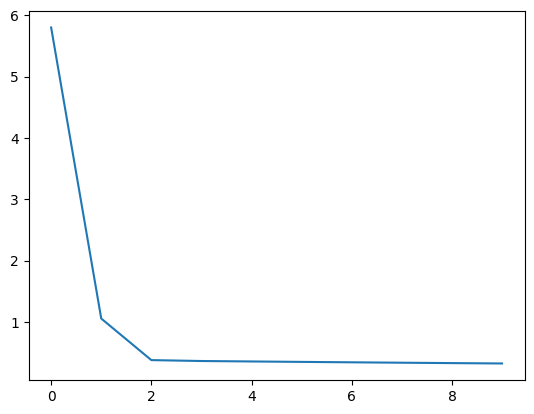

In [74]:
plt.plot(costs)

In [77]:
def predict (w, b, X):
  """
  Predict whether the label is 0 or 1 using learned logistic regression parameters (w, b)

  Arguments:
  w -- weights, a numpy array of size (num_px * num_px * 3, 1)
  b -- bias, a scalar
  X -- data of size (num_px * num_px * 3, number of examples)

  Returns:
  Y_prediction -- a numpy array (vector) containing all predictions (0/1) for the examples in X
  """
  n = X.shape[0]
  m = X.shape[1]
  Y_prediction = np.zeros((1, m))
  w = w.reshape((n, 1))

  A = sigmoid(w.T@X + b)
  Y_prediction = (A >= 0.5).astype(int)

  assert(Y_prediction.shape == (1, m))

  return Y_prediction


In [78]:
w = np.array([[0.1124579],[0.23106775]])
b = -0.3
X = np.array([[1.,-1.1,-3.2],[1.2,2.,0.1]])
print ("predictions = " + str(predict(w, b, X)))

predictions = [[1 1 0]]


## 5 - Merge all functions into a model

In [79]:
def model (X_train, Y_train, X_test, Y_test, num_iterations = 2000, learning_rate = 0.5, print_cost = False):
  """
  Builds the logistic regression model by calling the function you've implemented previously

  Arguments:
  X_train -- training set represented by a numpy array of shape (num_px * num_px * 3, m_train)
  Y_train -- training labels represented by a numpy array (vector) of shape (1, m_train)
  X_test -- test set represented by a numpy array of shape (num_px * num_px * 3, m_test)
  Y_test -- test labels represented by a numpy array (vector) of shape (1, m_test)
  num_iterations -- hyperparameter representing the number of iterations to optimize the parameters
  learning_rate -- hyperparameter representing the learning rate used in the update rule of optimize()
  print_cost -- Set to true to print the cost every 100 iterations

  Returns:
  d -- dictionary containing information about the model.
  """
  n = X_train.shape[0]
  m = X_train.shape[1]
  w, b = initialise_with_zeros(n)

  params, grads, costs = optimise(w, b, X_train, Y_train, num_iterations, learning_rate, print_cost)

  w = params["w"]
  b = params["b"]

  Y_train_predict = predict(w, b, X_train)
  Y_test_predict = predict(w, b, X_test)

  # Print train/test errors
  print("train accuracy: {} %".format(100 - np.mean(np.abs(Y_train_predict - Y_train)) * 100))
  print("test accuracy: {} %".format(100 - np.mean(np.abs(Y_test_predict - Y_test)) * 100))

  d = {
      "costs": costs,
      "Y_test_predict": Y_test_predict,
      "Y_train_predict" : Y_train_predict,
      "w" : w,
      "b" : b,
      "learning_rate" : learning_rate,
      "num_iterations": num_iterations
  }

  return d

In [80]:
d = model(train_set_x, train_set_y, test_set_x, test_set_y, num_iterations = 2000, learning_rate = 0.005, print_cost = False)
d

train accuracy: 99.04306220095694 %
test accuracy: 70.0 %


{'costs': [0.6931471805599453,
  0.5845083636993087,
  0.46694904094655476,
  0.3760068669480209,
  0.33146328932825125,
  0.30327306747438293,
  0.27987958658260487,
  0.26004213692587574,
  0.2429406846779662,
  0.2280042225672607,
  0.2148195137844964,
  0.20307819060644985,
  0.19254427716706862,
  0.18303333796883506,
  0.17439859438448874,
  0.16652139705400332,
  0.15930451829756614,
  0.15266732471296504,
  0.14654223503982336,
  0.14087207570310156],
 'Y_test_predict': array([[1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0,
         0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0,
         1, 0, 0, 1, 1, 0]]),
 'Y_train_predict': array([[0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0,
         0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0,
         0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0,
         0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0,
         1, 0, 0, 0

## 6 - Evaluating performance of the model

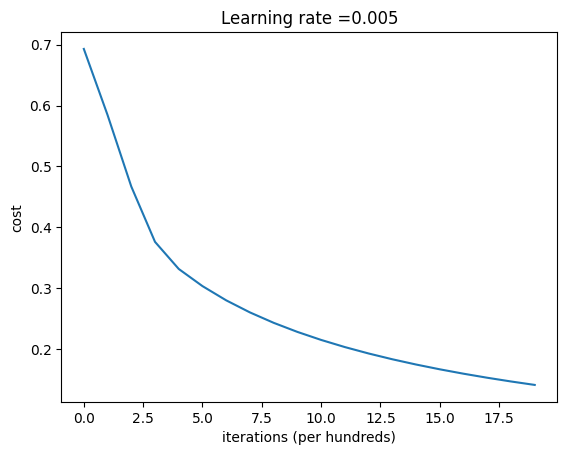

In [81]:
# Plot learning curve (with costs)
costs = np.squeeze(d['costs'])
plt.plot(costs)
plt.ylabel('cost')
plt.xlabel('iterations (per hundreds)')
plt.title("Learning rate =" + str(d["learning_rate"]))
plt.show()